In this notebook, we will implement the [Denoising Diffusion Probabilstic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

Diffusion Probabilistic Models (DPMs) are a type of probabilistic graphical model used for approximating distributions over high-dimensional spaces. They are parameterized Markov chains trained using variational inference to produce samples matching the data after finite time. The main advantage of using DPMs is that they can represent complex distributions and can easily handle multimodal distributions with overlapping modes.

DPMs have been used in a variety of applications such as image denoising, object recognition, and text classification. In this notebook, we will focus on how the Denoising DPM type can be used for image denoising. We will go over the steps of training a DDPM and apply it to a noisy image.

**tl;dr**: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample.

## Housekeeping

### Imports
The first step is to load in the packages we will need.

In [16]:
import math
import numpy as np
from inspect import isfunction
from functools import partial
from torchvision.transforms.functional import to_pil_image, resize

import PIL

from datasets import load_dataset

# for pretty printing
from rich import print, inspect, pretty

# for typing
from typing import Tuple, Union

# for testing
import unittest

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
from torch import nn, einsum
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataloading
We will work with the CelebFaces Attributes Dataset (CelebA). The CelebA dataset contains over 200,000 celebrity images. We will use the pre-processed version of the dataset which crops and aligns the images. The aligned and cropped version can be found [here](https://huggingface.co/datasets/huggan/CelebA-faces). 

### Staging
We will next view a few sample images from CelebA dataset.

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (C:/Users/Hedronstone/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Example images from CelebA-faces

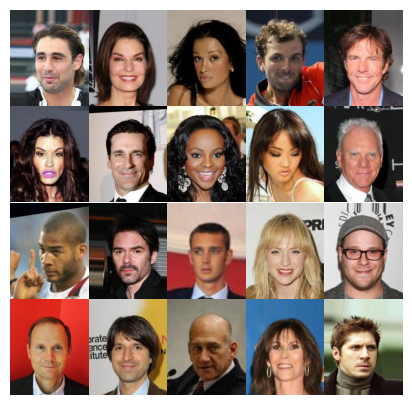

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid

dataset_name = "huggan/CelebA-faces"
dataset = load_dataset(dataset_name, split="train")

def image_grid(data, title="CelebA-faces"):
    "For displaying images from CelebA dataset"
    fig = plt.figure(figsize=(10,5))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 5),
                 axes_pad=0, share_all=True)
    
    for ax, im in zip(grid, dataset[:25]['image']):
        ax.imshow(im)
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    print(f"[bold magenta]Example images from {title}[/bold magenta]")
    plt.show()

image_grid(dataset)

As you can see, the images are of celebrities and contain different facial attributes such as Mustache, Smiling, Wearing_Hat, etc.

### Transforms

The author's of DDPM provide guidance on the set of transformations to apply to our images prior to the denoising process:

“We used random horizontal flips during training for CIFAR10; we tried training both with and without flips, and found flips to improve sample quality slightly. We also used random horizontal flips for all other datasets except LSUN Bedroom.” ([Ho et al., 2020, p. 14](zotero://select/library/items/P3D7SC8D)) ([pdf](zotero://open-pdf/library/items/6ZDJ4JA8?page=14&annotation=EAVYIZQK))

We will use Compose, ToTensor, Lambda, ToPILImage, CenterCrop, and Resize methods from the fantasticly rich [torchvision](https://pytorch.org/vision/stable/index.html) library.

In [19]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from PIL import Image

image_size = 32
        
# forward transform
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) -1),
])

### Logging
We incorporate a lightweight configuration class from [this repository](https://github.com/karpathy/minGPT/blob/master/mingpt/utils.py).

In [67]:
from ddpm.utils import CfgNode

# config class
config = CfgNode()

## Denoising DPM
DDPMs work by first constructing a low-dimensional representation of an image, then using this representation to denoise the image. All DDPMs have two key components: a diffusion (forward) process and a probabilstic model. The forward process is used to construct the low-dimensional representation, while the probabilistic model is used to denoise the image based on this representation.

### Forward Process
The forward process of a DDPM works by iteratively diffusing information about the image throughout the low-dimensional space until the image looks like pure noise. This diffusion process is controlled by a set of parameters that determine how quickly information spreads and how much information is retained at each iteration. 

We start by defining some variables:

$\mathbf{x}_{0}$ - the original image, before the destructive, noise-adding process

$\mathbf{x}_{T}$ - the final Gaussian noise, after the noise-adding process

The forward diffusion process starts with a regular image $\mathbf{x}_{0}$ and gradually transitions it to Gaussian noise $\mathbf{x}_{T}$.

Since diffusion models are composed of forward diffusion processes being repeatedly applied, there will be intermediate latent variables, $\mathbf{x}_{1},\mathbf{x}_{2}, \mathbf{x}_{i}, \dots, \mathbf{x}_{T-1}$. 

The overaching objective is to estimate $p(\mathbf{x}_{0})$, the distribution of our dataset, so that we can sample from it. But the distribution is conditional on these latent variables (a _latent variable model_), so we must sum out (or marginalize out) the latent variables to get the marginal likelihood function:

$$p(\mathbf{x_0}) = ∫p(\mathbf{x_0}|\mathbf{x_{1:T}})\mathrm{d}\mathbf{x_{1:T}}$$

The forward (and reverse) diffusion process is a stochastic process technically known as [Markov chains](https://en.wikipedia.org/wiki/Markov_chain). A Markov chain is a "memoryless" stochastic process. This is important for the forward process as it means the probability distribution for $\mathbf{x}_{t}$ is only conditional on $\mathbf{x}_{t-1}$. 

$$\quad q\left(\mathbf{x}_{t} \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}} \mathbf{x}_{t-1}, \beta_{t} \mathbf{I}\right)$$

So for our forward diffusion process, our variance is $\beta_{t}$ which is a variance taken from a pre-defined schedule. It increases over time. The mean is dependent on $\mathbf{x}_{t-1}$. To calculate out the Markov chain, we simply sample from this distribution at each step. Let's code this up.

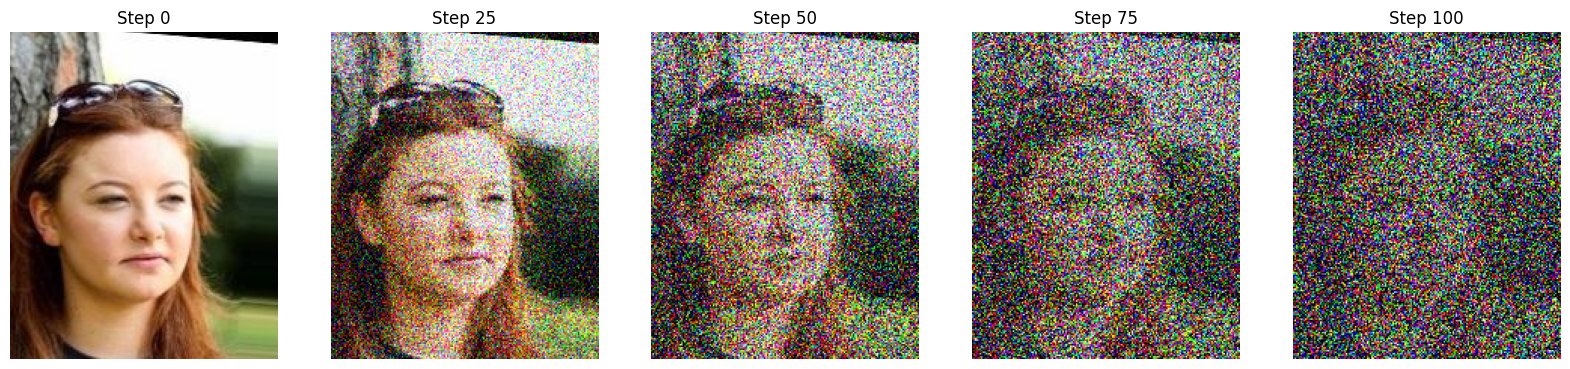

In [57]:
img = torch.from_numpy(np.array(dataset[301]['image']))
img = img.to(torch.float)
img /= 255.

n_steps = 100 # how many steps to take in this stochastic forward diffusion process
num_imgs_to_show = 5 # how many images to display
every_n_imgs = int(n_steps // (num_imgs_to_show-1)) # calculate to save image every n steps

beta_min, beta_max = 0.0001, 0.02
beta = torch.linspace(beta_min, beta_max, n_steps) # get variances $beta_t$ 

def full_forward_process(x_0, every_n_imgs): # actual forward process stepping
    x_t_prev = x_0
    img_to_plot = [img] # list of images to show

    for t in range(n_steps): # perform forward process for n_steps
        mean = (1-beta[t])*x_t_prev # calculate the mean
        var = beta[t] # get the variance from the variance schedule
        x_t = np.random.normal(mean, var**0.5, size=x_t_prev.shape) # get $q(x_{t} | x_{t-1})$
        
        if (t+1) % every_n_imgs == 0: # if it's time to save
            img_to_plot.append(np.clip(x_t,a_min=0,a_max=1) ) # save to list
        
        x_t_prev = x_t
        
    return img_to_plot


img_to_plot = full_forward_process(img, every_n_imgs)

f, axarr = plt.subplots(1,len(img_to_plot),figsize=(20,20)) # create subplots
for i in range(len(img_to_plot)):
    axarr[i].imshow(img_to_plot[i]) # show img
    axarr[i].set_axis_off()
    axarr[i].set_title(f'Step {every_n_imgs*i}')

Since the process is a Markov chain, random Gaussian noise can be sampled at any arbitrary timestep and the following holds true:

$$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_{0}\right):=\prod_{t=1}^{T} q\left(\mathbf{x}_{t} \mid \mathbf{x}_{t-1}\right)$$

For a given timestep $T$, we can get the probability distribution by multiplying the probability distributions for all the previous timestep $t=1,2,\dots,T$ since those probability distributions are independent.

$$ q(\mathbf{x}_t | \mathbf{x}_0 ) = \mathcal{N}(\mathbf{x}_t; \sqrt{\overline{\alpha}_t}\mathbf{x}_0, (1-\overline{\alpha}_t)\mathbf{I})$$

Where &nbsp; $$\overline{\alpha}_t = \prod^T_{i=1} \alpha_i$$ and $$\alpha_t = 1 - \beta_t$$

In [68]:
def extract(consts, t):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

n_steps = 1000 # T

# create β1,...,βT linearly increasing variance schedule
beta = torch.linspace(0.0001, 0.02, n_steps)
alpha = 1. - beta # αt = 1−βt
alpha_bar = torch.cumprod(alpha, axis=0) # αt_bar
sigma2 = beta # σ^2 = β

def q_xt_x0(x0, t):
    "Get the q(xt|x0) distribution. Equation #4 from paper."
    # 1. Gather αt and compute (sqrt(αt_bar) * x0) for the mean
    mean = extract(alpha_bar, t) ** 0.5 * x0
    
    # 2. Get variance σ
    var = 1 - extract(alpha_bar, t)
    
    # 3. Return mean µ and variance σ
    return mean, var

def q_sample(x0, t, eps=None):
    """Sample from q(xt|x0). Equation #4 from paper."""
    # 1. Sample epsilon from Gaussian distribution
    if eps is None:
        eps = torch.randn_like(x0)
        
    # 2. Get mean µ and variance σ
    mean, var = q_xt_x0(x0, t)
    
    # 3. Sample from q(xt|x0)
    return mean + (var ** 0.5) * eps

### Reverse Process
The **reverse process** is a Markov chain with learned Gaussian transitions starting from Gaussian noise $\mathbf{x}_{T}$ to an actual image $\mathbf{x}_{0}$

Definition: $$ p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)\right) $$

Where the mean and variance for our distribution is defined by two functions: $$\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)$$

Training a diffusion model is about learning these mean and variance functions for the reverse diffusion process, where
$\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right)$ and $\mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)$ are neural networks parameterized by weights $θ \in Θ$.

In [69]:
def p_sample(xt, t, eps_theta):
    alpha_bar = diffusion.alpha_bar
    alpha = diffusion.alpha

    alpha_bar = extract(alpha_bar, t)
    alpha = extract(alpha, t)
    eps_coef = (1 - alpha) / (1 - alpha_bar) ** 0.5

    mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
    var = extract(sigma2, t)
    eps = torch.randn(xt.shape, device=xt.device)

    return mean + (var ** 0.5) * eps

### Training Objective
The mean and variance functions of the reverse diffusion process are learned using the simplified training objective:

$$ L_{\text{simple}}(\theta) := \mathbb{E}_{t, \mathbf{x}_{0}, \boldsymbol{\epsilon}} \left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}\left(\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}, t\right)\right\|^{2}\right] $$

Which was derived from the original mean squared error reconstruction loss between the reverse process posterior mean and the forward process posterior mean:

$$ L_T = \mathbb{E}_{q}[D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right) \| p\left(\mathbf{x}_{T}\right)\right)]$$

In [70]:
def loss(x0, noise=None):
    # 1. Get batch size
    batch_size = x0.shape[0]
    
    # 2. Get random t for each sample in the batch
    t = torch.randint(0, n_steps, (batch_size,), device=x0.device, dtype=torch.long)
    
    # 3. Sample epsilon from Gaussian distribution
    if noise is None:
        noise = torch.randn_like(x0)
    
    # 4. Sample xt for q(xt|x0)
    xt = q_sample(x0, t, eps=noise)
    
    # 5. Get predicted noise
    eps_theta = eps_model(xt, t)
    
    # 6. Calculate and return loss
    return F.mse_loss(noise, eps_theta)

### Unet

We will need $\epsilon_\theta$ which is our neural network! This neural network needs to take in an image $x_t$ , a timestep $t$, and output another image of the same shape $\epsilon$ , the predicted noise. We use a U-net architecture slightly modified to be conditioned on the timestep. The timestep information is injected into the neural network using sinusoidal embeddings, similar to how position information is injected into Transformers. We will import a Unet from [labmlai](https://github.com/labmlai/annotated_deep_learning_paper_implementations/tree/master/labml_nn/diffusion/ddpm), just to focus on implementing the training process rather than architectural details.

In [71]:
# load unet model
from labml_nn.diffusion.ddpm.unet import UNet

eps_model = UNet(    
    image_channels = 3,
    n_channels = 64,
    ch_mults = [1, 2, 2, 4],
    is_attn = [False, False, False, True],
).to(device)

### Denoising Class
We will create a denoising class for managing our variables and functions for the training loop.

In [72]:
class DenoiseDiffusion:
    def __init__(self, eps_model, n_steps, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
        self.n_samples = 10
        self.image_channels = 3
        self.image_size = 32
        self.device = device
        
    def q_xt_x0(self, x0, t):
        mean = extract(self.alpha_bar, t) ** 0.5 * x0
        var = 1. - extract(self.alpha_bar, t)
        return mean, var
    
    def q_sample(self, x0, t, eps=None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps
    
    def p_sample(xt, t, eps_theta):
        alpha_bar = diffusion.alpha_bar
        alpha = diffusion.alpha

        alpha_bar = extract(alpha_bar, t)
        alpha = extract(alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** 0.5

        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = extract(sigma2, t)
        eps = torch.randn(xt.shape, device=xt.device)

        return mean + (var ** 0.5) * eps
    
    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)
        return F.mse_loss(noise, eps_theta)

## DDPM Training Algorithm
![image](images/algorithm_1.jpg) 
1. Randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in the noisy image to our model.
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image.

We will implement this algorithm below. Our procedure will randomly select the timestep and create the noisy image before setting up our input and ground truch tensors for the model forward pass and loss calculation.

In [75]:
# instantiate diffusion class
diffusion = DenoiseDiffusion(
    eps_model = eps_model,
    n_steps=n_steps,
    device=device,
)

### Optimizer

In [76]:
optimizer = torch.optim.Adam(eps_model.parameters(), lr=2e-5)

### Training Loop

In [81]:
from torchvision.utils import save_image

# ======== housekeeping =========

def transforms(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    return examples

transformed_dataset = dataset.with_transform(transforms)

# to accelerate training computations
torch.backends.cudnn.benchmark = True

# ================================

# training epochs
epochs = 1

# train batch size
batch_size = batch_size

# stage data
dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# for reproducibility
g = torch.Generator(device=device).manual_seed(3141)

# Loop
for epoch in range(epochs):
    for step, batch in enumerate(tqdm(dataloader)):
                
        # get images from training batch (inefficient)
        train_batch = batch['image']
        
        # move data to device
        train_batch = train_batch.to(device)
        
        # get MSE loss
        loss = diffusion.loss(train_batch)
                
        if step % 1000 == 0:
            print("[bold magenta]Loss:[/bold magenta] %.4f" % (loss.item()))
        
        # collect gradients
        loss.backward()
        # perform optimization
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

  0%|                                                                                                                                              | 0/3166 [00:00<?, ?it/s]

Loss: 0.4122

 32%|█████████████████████████████████████████▍                                                                                         | 1000/3166 [02:23<05:14,  6.88it/s]

Loss: 0.0584

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 2000/3166 [04:46<02:46,  7.00it/s]

Loss: 0.0316

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3000/3166 [07:09<00:23,  6.97it/s]

Loss: 0.0376

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [07:34<00:00,  6.97it/s]


### Save Weights

In [ ]:
path = 'celeba.pt'
torch.save({
    'epoch': step,
    'model_state_dict': eps_model,
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, path)

## Sampling
We proceed along the Markov chain in the reverse direction iteratively denoising the image at each timestep $t$.
![image](./images/algorithm_2.jpg) 


In [87]:
g = torch.Generator(device=device).manual_seed(3141) # for reproducibility 

# load model
PATH = ".\pretrained_weights\celeba.pt"
eps_model = torch.load(PATH)['model_state_dict']
eps_model.eval()

# instantiate DDPM
diffusion = DenoiseDiffusion(
    eps_model=eps_model,
    n_steps=n_steps,
    device=device,)

alpha = 1. - beta # αt = 1−βt
alpha_bar = torch.cumprod(alpha, axis=0).to(device) # αt_bar = ∏ αs 
sigma2 = beta # σ^2 = β

# place on device
alpha = alpha.to(device)
sigma2 = sigma2.to(device)

For steps $T$...$t_1$:

Starting with: &nbsp; $$x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$$

We next sample from: &nbsp; $${p_\theta}(x_{t-1}|x_t)$$

Expressed as an approximate Gaussian: &nbsp; $$\mathcal{N}\big(x_{t-1};{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big)$$

And paramaterized: &nbsp; $$x_{t-1} = {\mu_\theta}(x_{t}, t) + {\sigma_t}z$$

Where &nbsp; $${\mu_\theta}(x_{t}, t) = \frac{1}{\sqrt{\alpha_t}} \Big(x_t - \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}{\epsilon_\theta}(x_t, t) \Big)$$

And z is: &nbsp; $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

At $t=0$:

$$x_0 \approx \hat{x}_0 = \frac{1}{\sqrt{\bar\alpha}}
         \Big( x_t - \sqrt{1 - \bar\alpha_t}{\epsilon_\theta}(x_t, t) \Big)$$


In [92]:
# steps 1 - 5
n_steps = 800
n_samples = 10
n_frames = 200
interval = n_steps // n_frames
video_path =  "./results/celeba2.mp4"
image_channels = 3
# image_size = 32

frames = []

xt = torch.randn([n_samples, image_channels, image_size, image_size], device=device)

for t_inv in tqdm(range(n_steps)):
    t_ = n_steps - t_inv
    t  = xt.new_full((config.n_samples,), t_, dtype=torch.long)

    with torch.no_grad():
        eps_theta = eps_model(xt, t)
     
    # collect denoised image at each given interval
    if t_ % interval == 0:
        alpha_bar = diffusion.alpha_bar
        alpha_bar = extract(alpha_bar, t)
        x0 = (xt - (1 - alpha_bar) ** 0.5 * eps_theta) / (alpha_bar ** 0.5)
        frames.append(x0[0])
    
    xt = p_sample(xt, t, eps_theta)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:10<00:00, 73.01it/s]


With $x_0$ computed, we are now ready to display the generated image using our `show_image` function.

### Display Generated Image

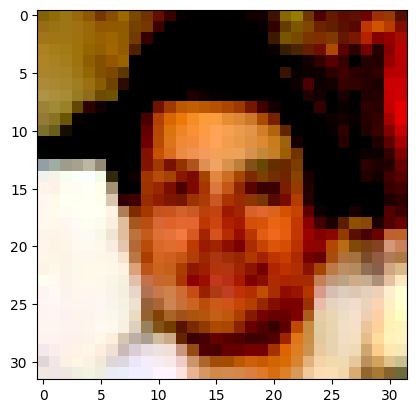

In [109]:
# modify approximate x_0 
def show_image(img, title=""):
    img = img.clip(0, 1)
    img = img.cpu().numpy()
    plt.imshow(img.transpose(1, 2, 0))
    plt.title(title)
    plt.show()

show_image(x0[7])

# # for video
# import imageio
# # 10 second video
# writer = imageio.get_writer(path, fps=len(frames) // 20)

# for f in frames:
#     f = f.clip(0, 1)
#     f = to_pil_image(resize(f, [368, 368]))
#     writer.append_data(np.array(f))

# writer.close()

# from IPython.display import Video

# Video(r".\results\celeba.mp4")